In [4]:
from matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
import numpy as np
from dataclasses import dataclass
import joypy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('Metabolic Syndrome.csv', sep = ',')

- mettre des echelles logarithmique pour mieux visualiser les minorités
- **regarder les algo pour detecter des outlier (isolation forest) skearn.ensemble.IsolationForest**
- essayer de faire un : one hot coding 
- faire une pca (en selectionnant nos colonnes) numerique et un autre nom numerique (multiple factor analyses) 
- word2vec
- sklearn.decomposition.FactorAnalysis

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay


def func_1(df_dist):
    size_sample = df_dist.shape[0]
    for col in df_dist.columns:
        if col == "MetabolicSyndrome":
            break

        isodetector = IsolationForest(max_samples=df_dist.shape[0], random_state=0)
        isodetector.fit(df_dist[[f"{col}", f"MetabolicSyndrome"]])

        outlier = isodetector.predict(df_dist[[f"{col}", f"MetabolicSyndrome"]])

        dico = {f"{col}":df_dist[col], "MetabolicSyndrome":df_dist["MetabolicSyndrome"]}
        df_temp = pd.DataFrame(data=dico)

        disp = DecisionBoundaryDisplay.from_estimator(
        isodetector,
        df_temp,
        response_method="predict",
        alpha=0.5,
        )

        df_temp.insert(2, "outliers", outlier, True)
        data_inliner = df_temp.loc[df_temp["outliers"]!=-1]

        index_list = df_temp.index[df_temp["outliers"]==-1]

        scatter = plt.scatter(data_inliner[f"{col}"], data_inliner["MetabolicSyndrome"], c=data_inliner[f"{col}"],s=20, edgecolor="k")
        plt.title(f"outlier identification for {col}")
        plt.show()

        df_dist = df_dist.drop(index_list)
    print(f"{round(1-df_dist.shape[0]/size_sample)}% of the set of patients with MS was sorted out as outlier")
    return df_dist

With patients with MS : 

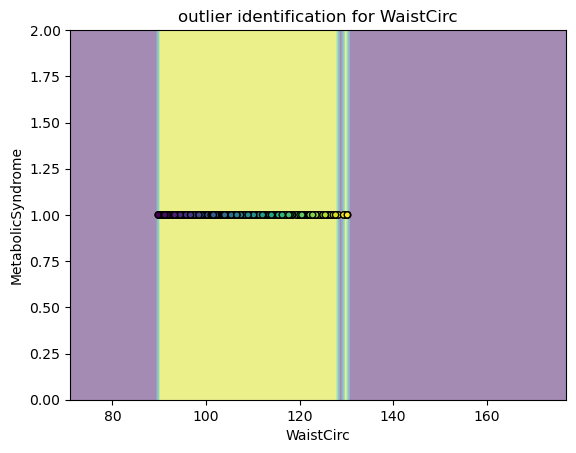

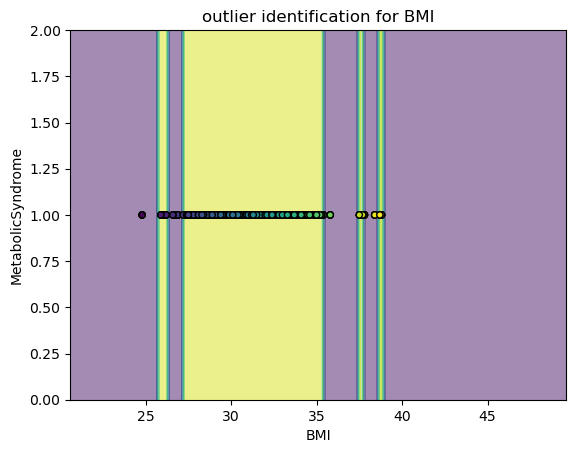

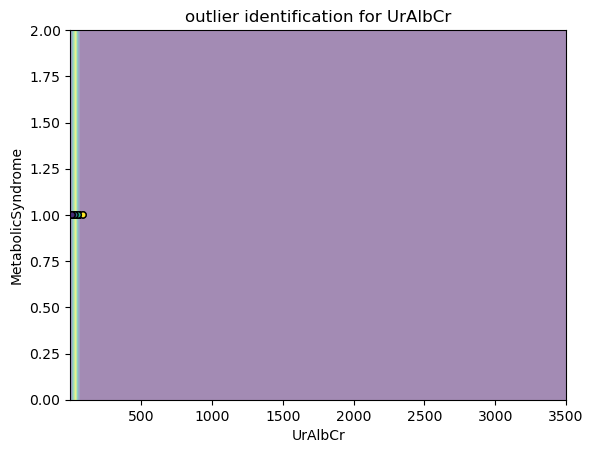

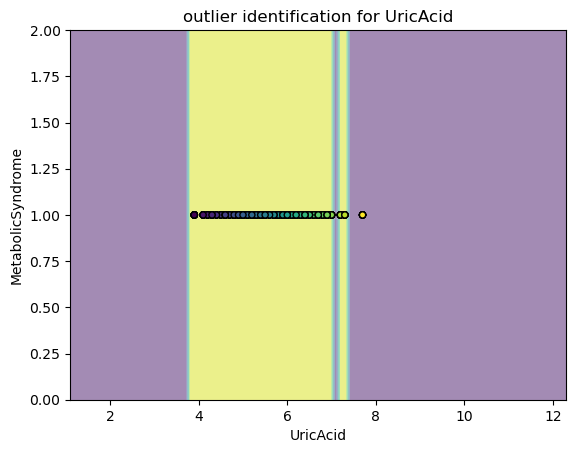

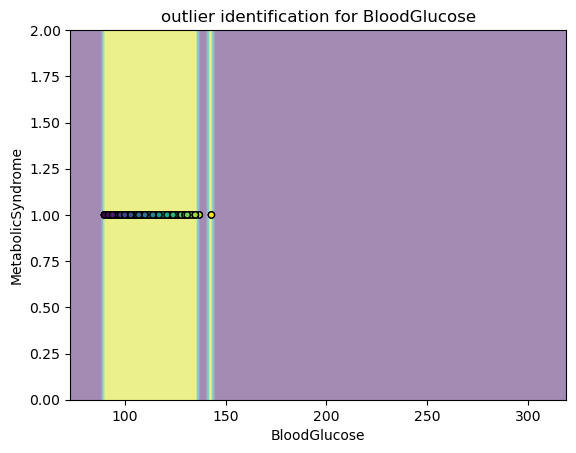

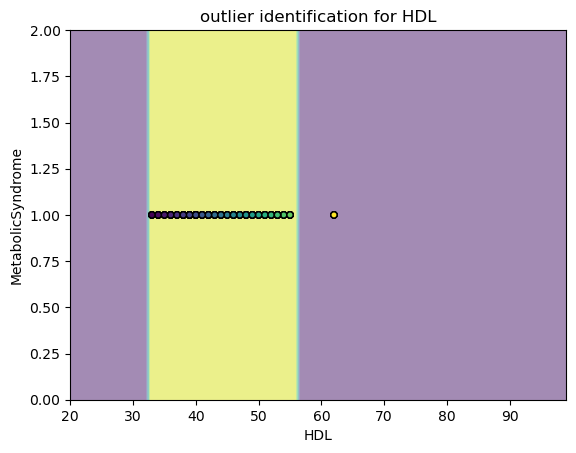

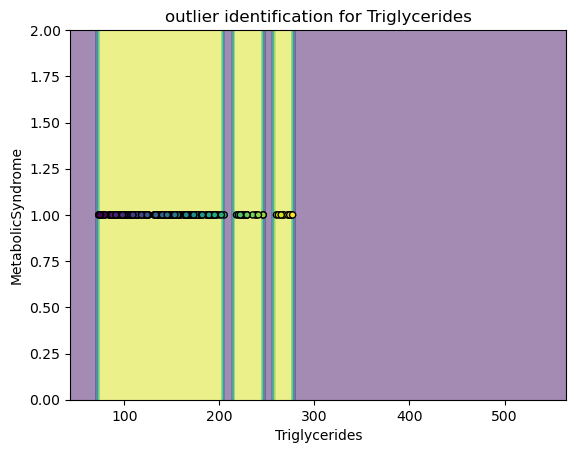

1% of the set of patients with MS was sorted out as outlier


In [6]:
df_dist = df.drop(columns=["seqn",'Albuminuria', "Age", "Income"]).select_dtypes("number")
df_dist = df_dist.dropna().drop(index=2200)
df_dist = df_dist.loc[df_dist["MetabolicSyndrome"]==1]
size_sample = df_dist.shape[0]

df_H = func_1(df_dist)

With healthy patients : 

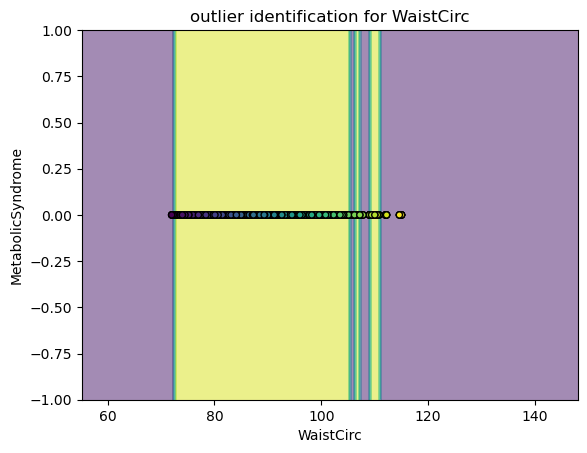

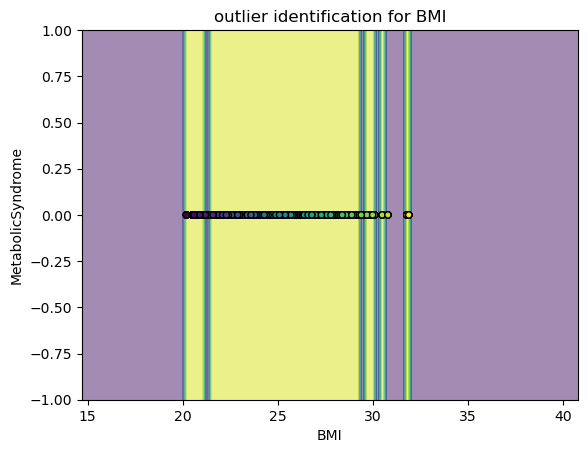

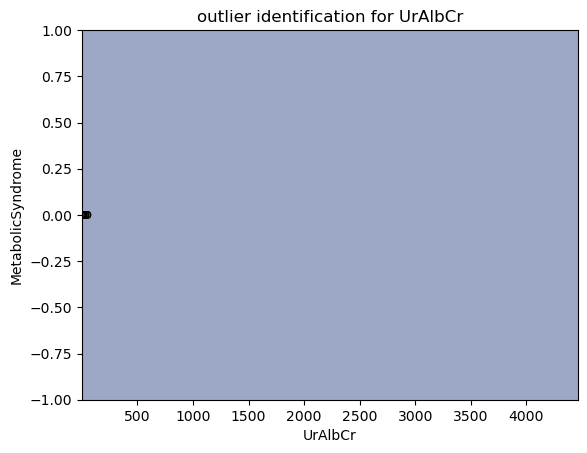

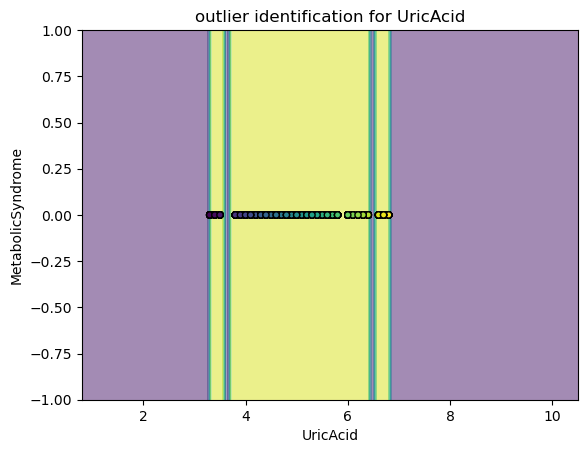

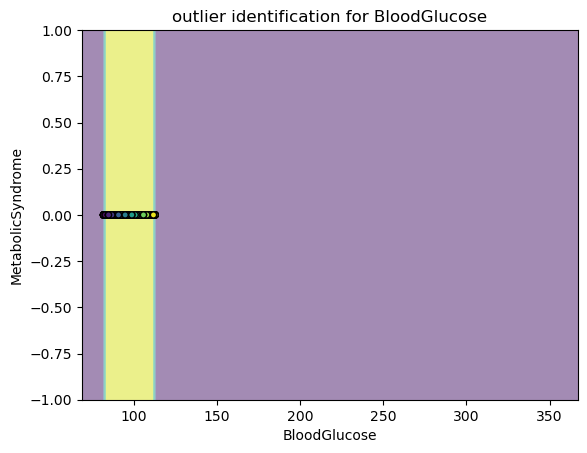

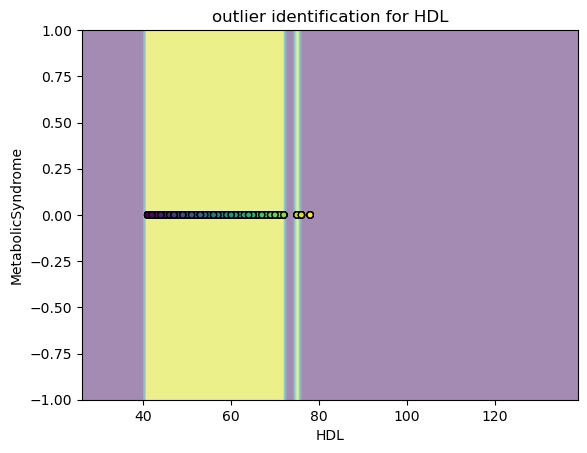

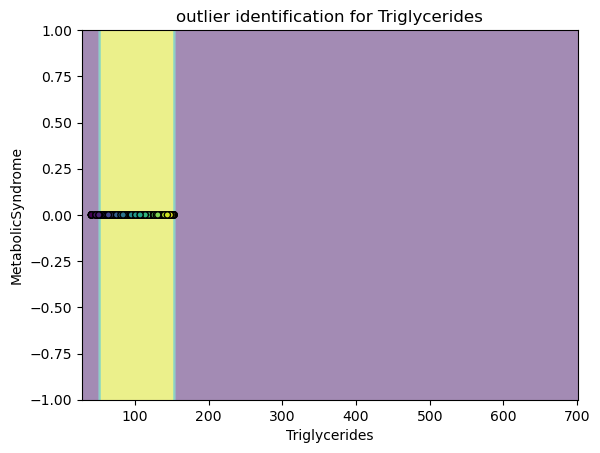

1% of the set of patients with MS was sorted out as outlier


In [7]:
df_dist = df.drop(columns=["seqn",'Albuminuria', "Age", "Income"]).select_dtypes("number")
df_dist = df_dist.dropna().drop(index=2200)
df_dist = df_dist.loc[df_dist["MetabolicSyndrome"]==0]
size_sample = df_dist.shape[0]

df_MS = func_1(df_dist)

In [8]:
df_final = pd.concat([df_H, df_MS])

print(f"Once every outlier taken out, the final dataframe is {round((df_final.shape[0]/df.shape[0])*100, 1)}% of the initial dataframe")

Once every outlier taken out, the final dataframe is 28.8% of the initial dataframe


We now filter the original dataframe by using the `df_final` as a reference indexer.

In [9]:
wrong_index = set(df.index) - set(df_final.index)

df = df.drop(list(wrong_index))

Créer un dico des index des outliers pour chaque colonne

In [10]:
def func():
    #cleaning of edgecases
    df_num = df.drop(columns=['Age','Sex','Marital', 'Race', 'Albuminuria', "MetabolicSyndrome"])
    df_num.describe()

#idea one : use 98% of sample from the median value to eliminate edgecases
    med_list = {col : sorted(df_num[col])[len(df_num[col])//2] for col in df_num.columns}
    lim = round(0.90*df_num.shape[0])

#index all edgevalues
    med_index = df_num.shape[0]//2
    lower_lim = (df_num.shape[0]//2)-lim//2
    upper_lim = (df_num.shape[0]//2)+lim//2

#replace all values bigger or lesser than edgevalues with None
    for col, med in med_list.items():
        if col == "seqn":
            continue
        else:
            df_num = df_num.sort_values(by=[col])
            liste_col = df_num[col]
            liste_col[0:lower_lim] = None
            liste_col[upper_lim:df_num.shape[0]] = None     
            df_num[col] = [i for i in liste_col]
            df_num = df_num.sort_values(by=['seqn'])
    return df_num

df_num = func()
    
for col in df_num.columns:
    df[col] = df_num[col]   



C:\Users\matte\AppData\Local\Temp\ipykernel_15720\1810940538.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liste_col[0:lower_lim] = None
C:\Users\matte\AppData\Local\Temp\ipykernel_15720\1810940538.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liste_col[upper_lim:df_num.shape[0]] = None
C:\Users\matte\AppData\Local\Temp\ipykernel_15720\1810940538.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  liste_col[0:lower_lim] 

In [11]:
sex_colors = {'Male':'#377eb8', 'Female':'#f781bf'}
marital_colors = {'Separated':'#50b131', 'Divorced':'#bb9832', 'Widowed':'#36ada4', 'Single':'#e866f4', 'Married':'#f77189'}
race_colors = {'White':'#66c2a5', 'Black':'#fc8d62', 'Asian':'#8da0cb', 'MexAmerican':'#e78ac3', 'Hispanic':'#a6d854', 'Other':'#b3b3b3'}

In [12]:
def check_met(value):
    if value == 1:
        return 'Metabolic Syndrome'
    else:
        return 'Healthy'

df['Metabolic_Dist'] = df['MetabolicSyndrome'].apply(check_met)

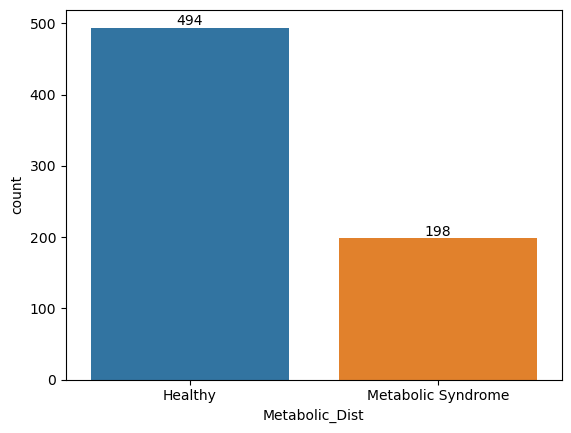

In [13]:
met_dist = sns.countplot(df, x = 'Metabolic_Dist')

counts = df['Metabolic_Dist'].value_counts()

for i, count in enumerate(counts):
    met_dist.text(i, count, str(count), ha='center', va='bottom')

In [14]:
df['Sex'] = df['Sex'].astype('string').fillna('NaN')
df['Marital'] = df['Marital'].astype('string').fillna('NaN')
df['Race'] = df['Race'].astype('string').fillna('NaN')

fig = px.sunburst(df, path = ['Sex', 'Marital', 'Race'], color = 'Sex', color_discrete_map = sex_colors)
fig.update_traces(textinfo = "label + value")

fig.update_layout(autosize=False, width=1000,height=800)

In [15]:
def kde_boxplot(df,df_col):
    for col in df_col:
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        
        sns.histplot(df, x = col, hue = 'Metabolic_Dist', kde = True, multiple="stack", ax=axes[0])
        
        sns.boxplot(df, y = 'Sex', x = col, hue = 'Metabolic_Dist', ax=axes[1])
        
        fig.suptitle(f'Numeric Feature : {col}', fontsize=16, fontweight='bold')
        fig.subplots_adjust(wspace=0.2)
        plt.show()

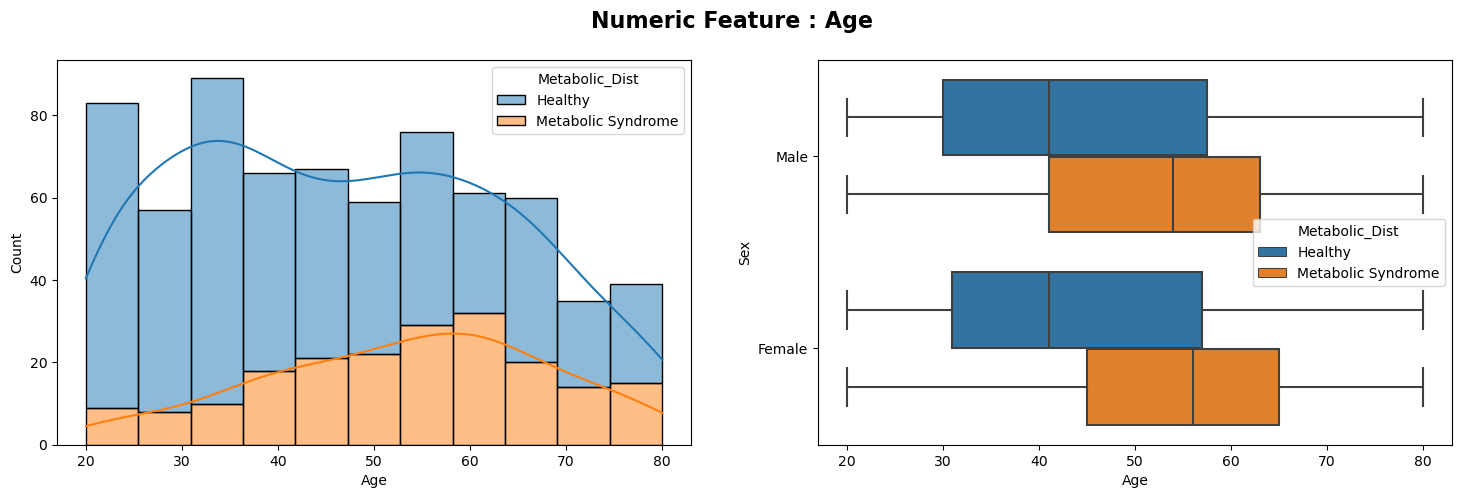

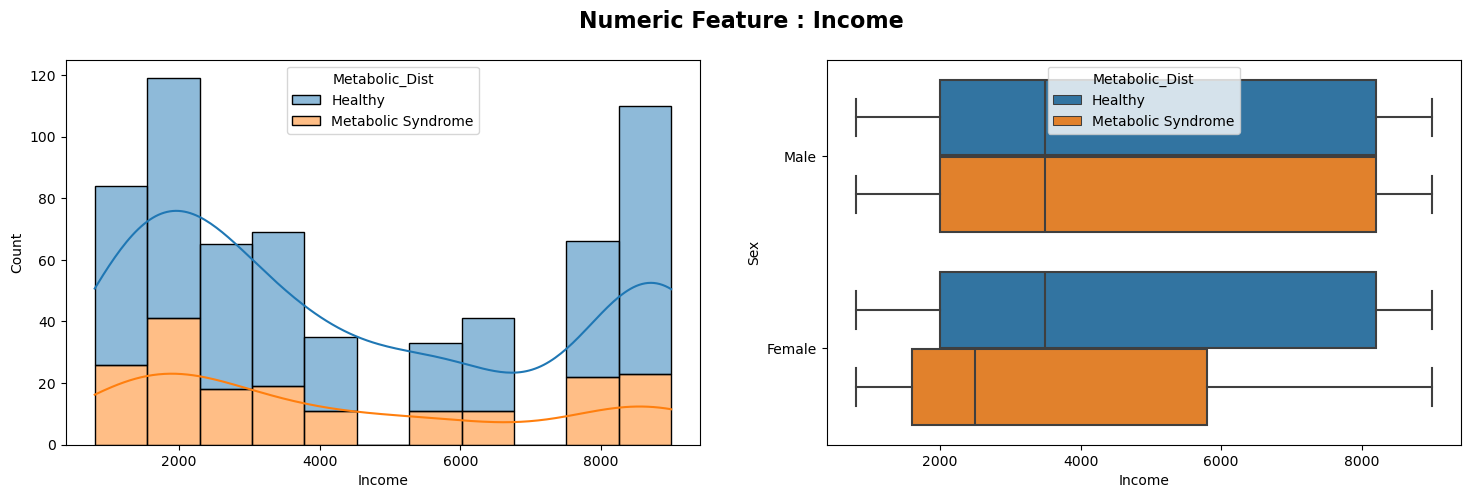

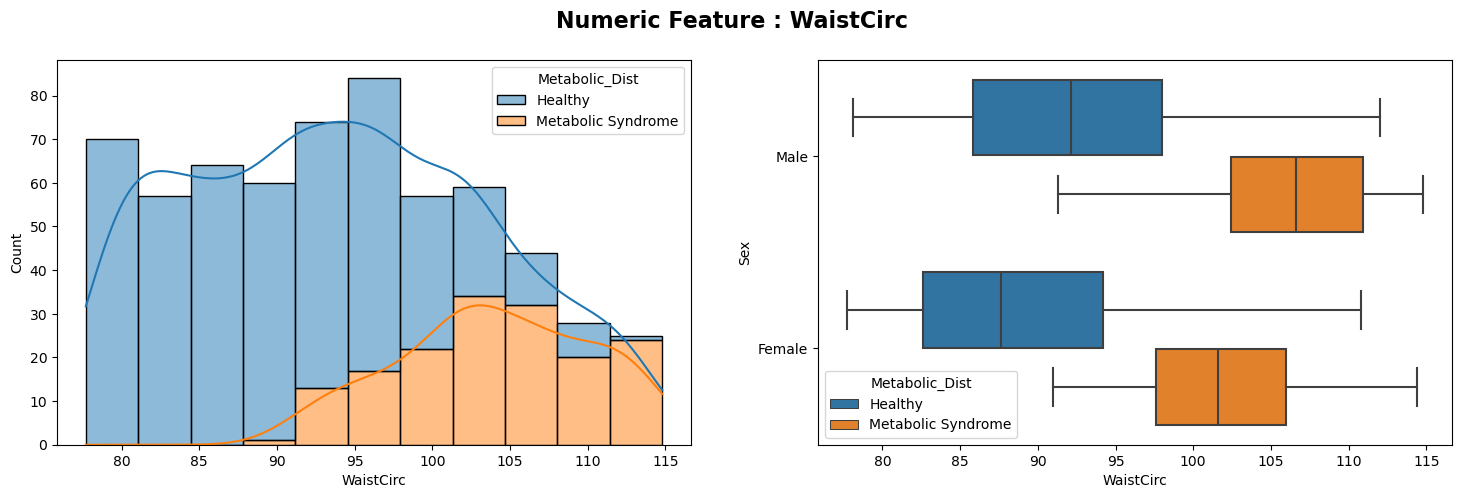

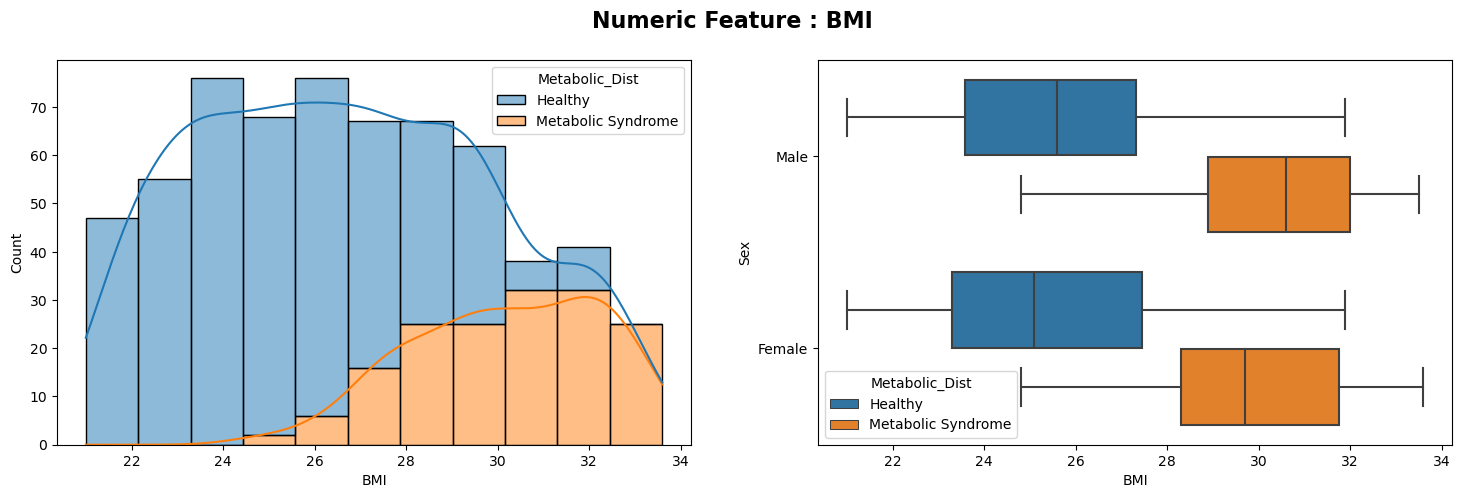

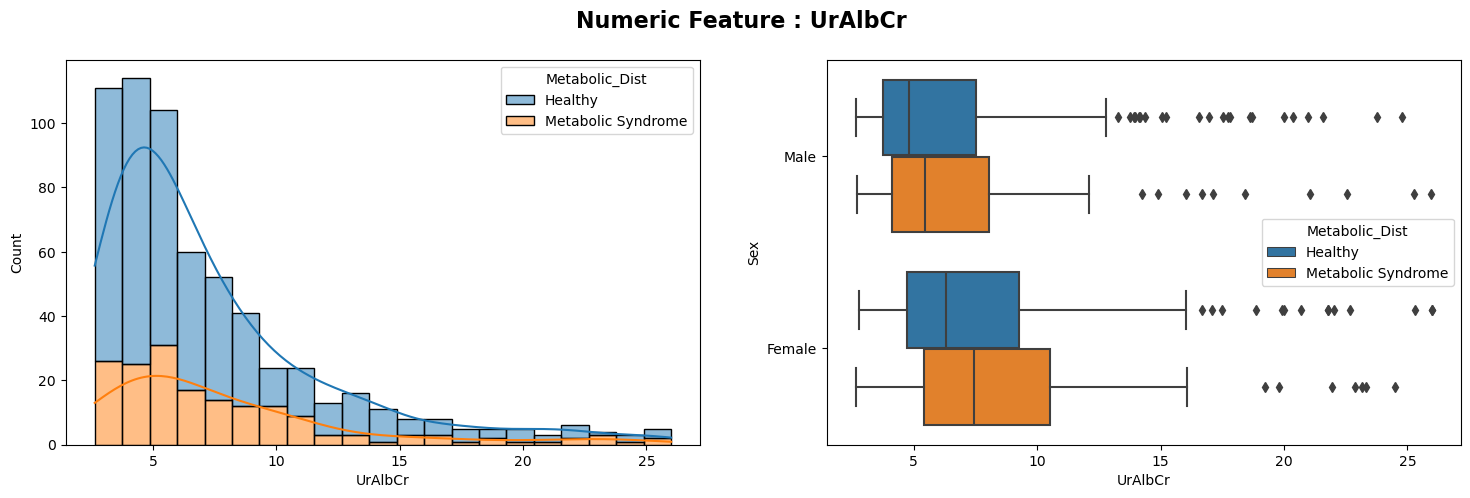

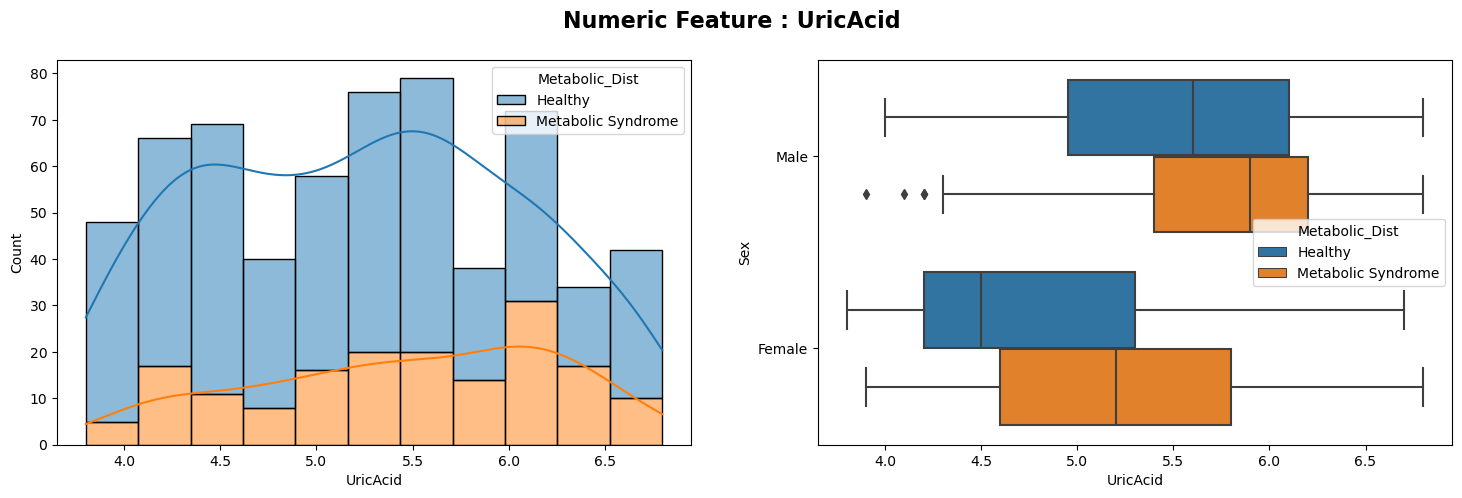

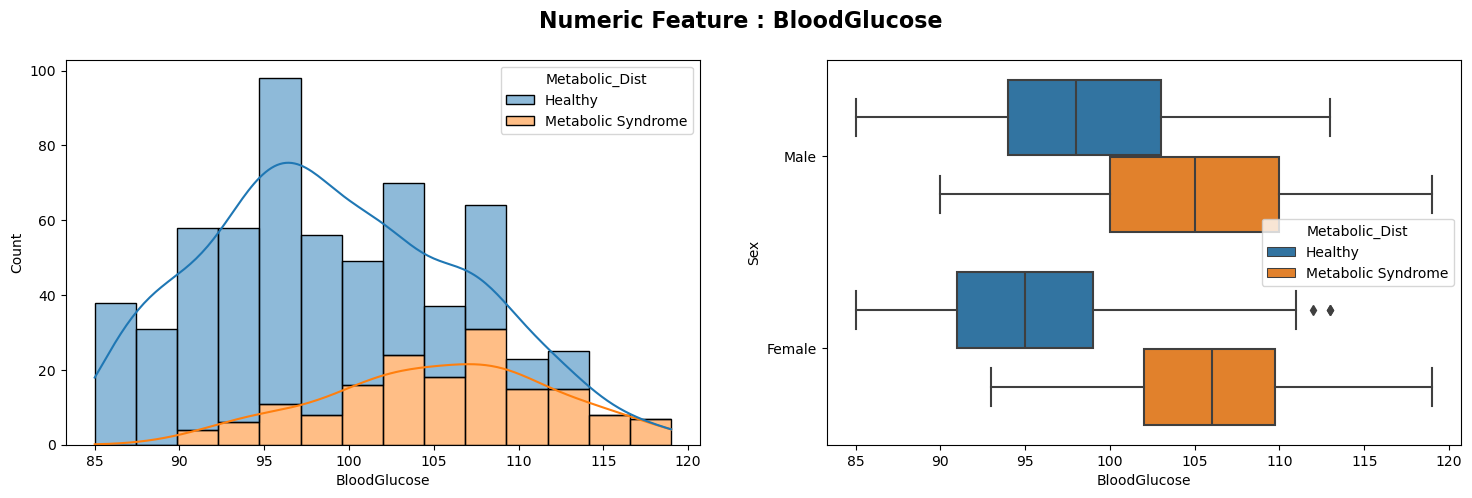

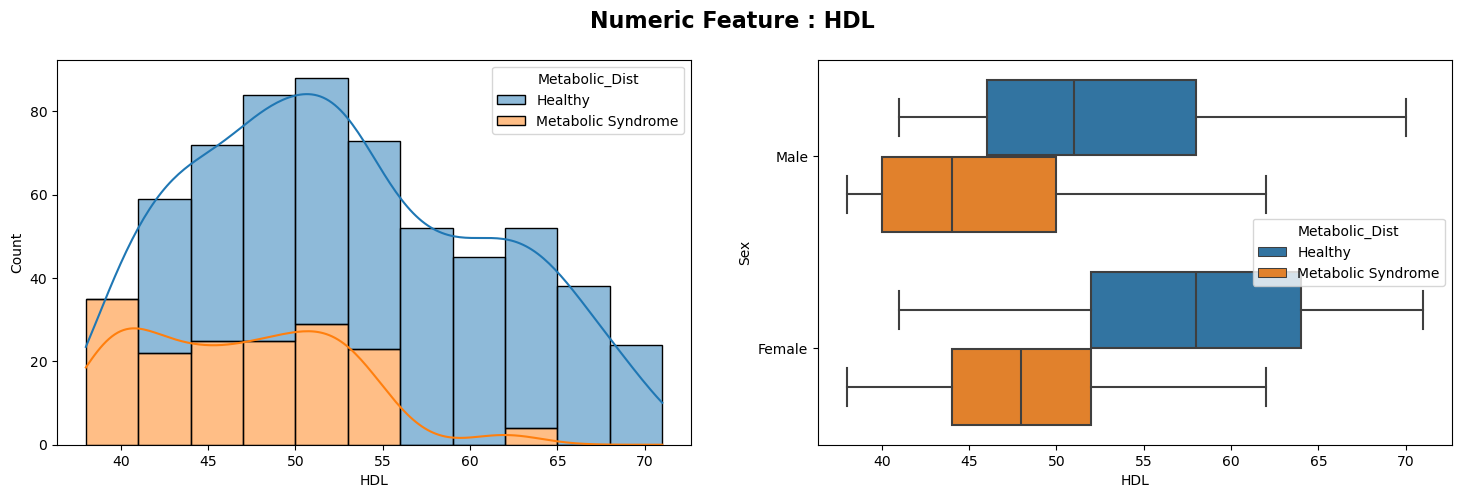

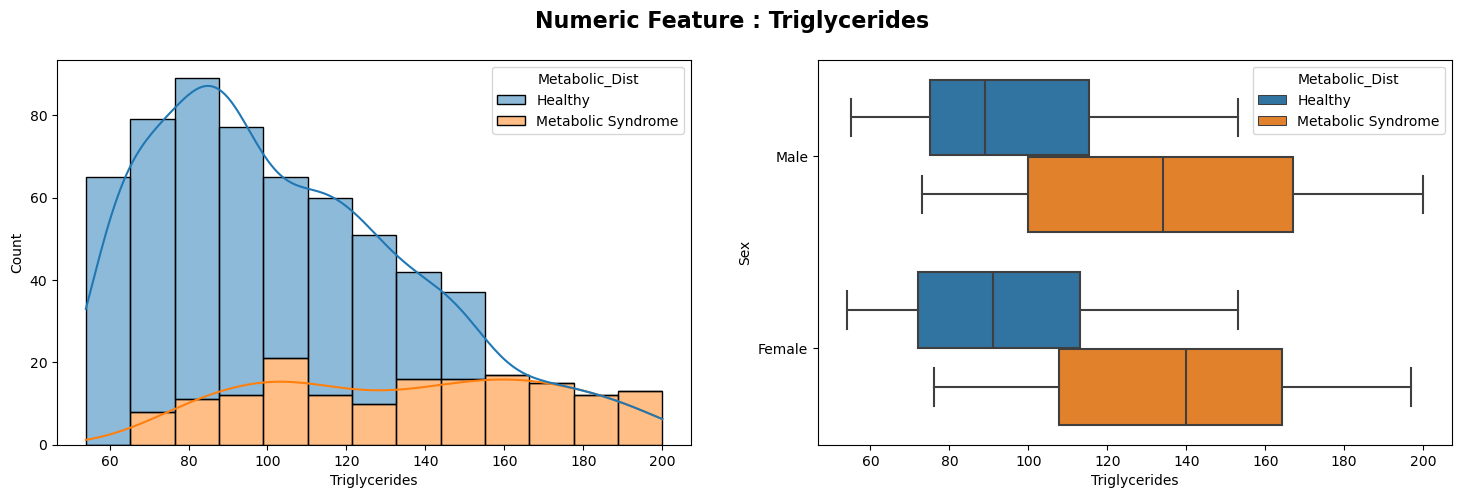

In [16]:
df_col=df.drop(columns=["seqn",'Albuminuria','MetabolicSyndrome']).select_dtypes("number")

kde_boxplot(df,df_col)